In [281]:


import os

import numpy as np 
import pandas as pd 
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F     
import matplotlib.pyplot as plt


from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [282]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [283]:
data_dir_train = '/home/wpanfil/Documents/Own_Projects/jezyki_skryptowe/proj5/flowers-recognition/flowers/train'
data_dir_validate = '/home/wpanfil/Documents/Own_Projects/jezyki_skryptowe/proj5/flowers-recognition/flowers/validate'
data_dir_test = '/home/wpanfil/Documents/Own_Projects/jezyki_skryptowe/proj5/flowers-recognition/flowers/test'

In [284]:
size_pictures = 100
data_transforms = transforms.Compose([transforms.Resize((size_pictures, size_pictures)),
                                 transforms.ToTensor()])

In [285]:
dataset = ImageFolder(root=data_dir_train,transform=data_transforms)
data_validate = ImageFolder(root=data_dir_validate,transform=data_transforms)
data_test = ImageFolder(root=data_dir_test,transform=data_transforms)
print(len(dataset), len(data_validate), len(data_test))

3019 644 654


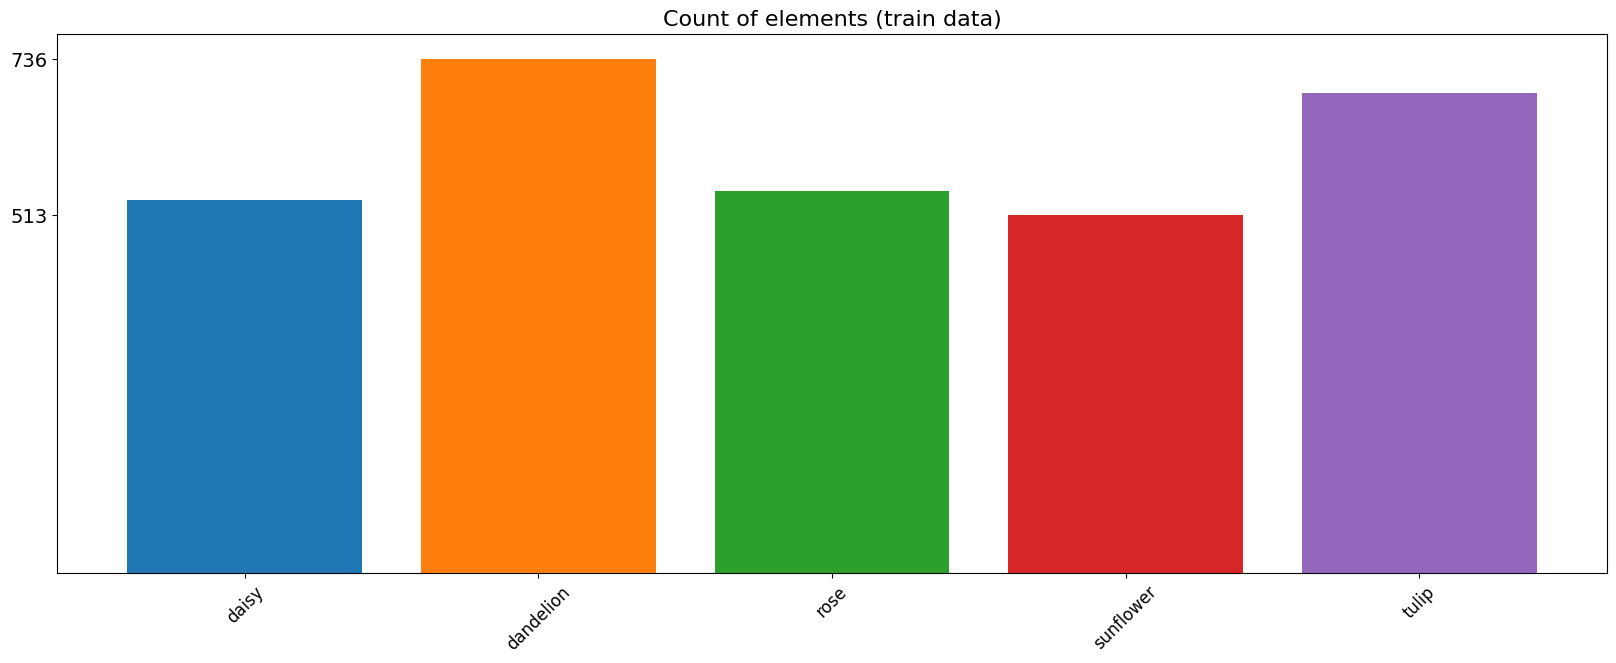

In [286]:
labels_count = {}

for image in dataset.imgs:
    label = image[1]
    
    if label not in labels_count.keys():
        labels_count[label] = 0
    labels_count[label] += 1
    
class_counts = labels_count.copy()

#Visualize
plt.figure(figsize=(20, 7));

for n,key in enumerate(labels_count):
    plt.bar(list(labels_count.keys())[n],
            list(labels_count.values())[n]);  
    
plt.title('Count of elements (train data)', fontsize=16)
plt.xticks(range(len(dataset.classes)), dataset.classes, rotation=45, fontsize=12)
plt.yticks((min(list(labels_count.values())), max(list(labels_count.values()))), fontsize=14)
plt.show()

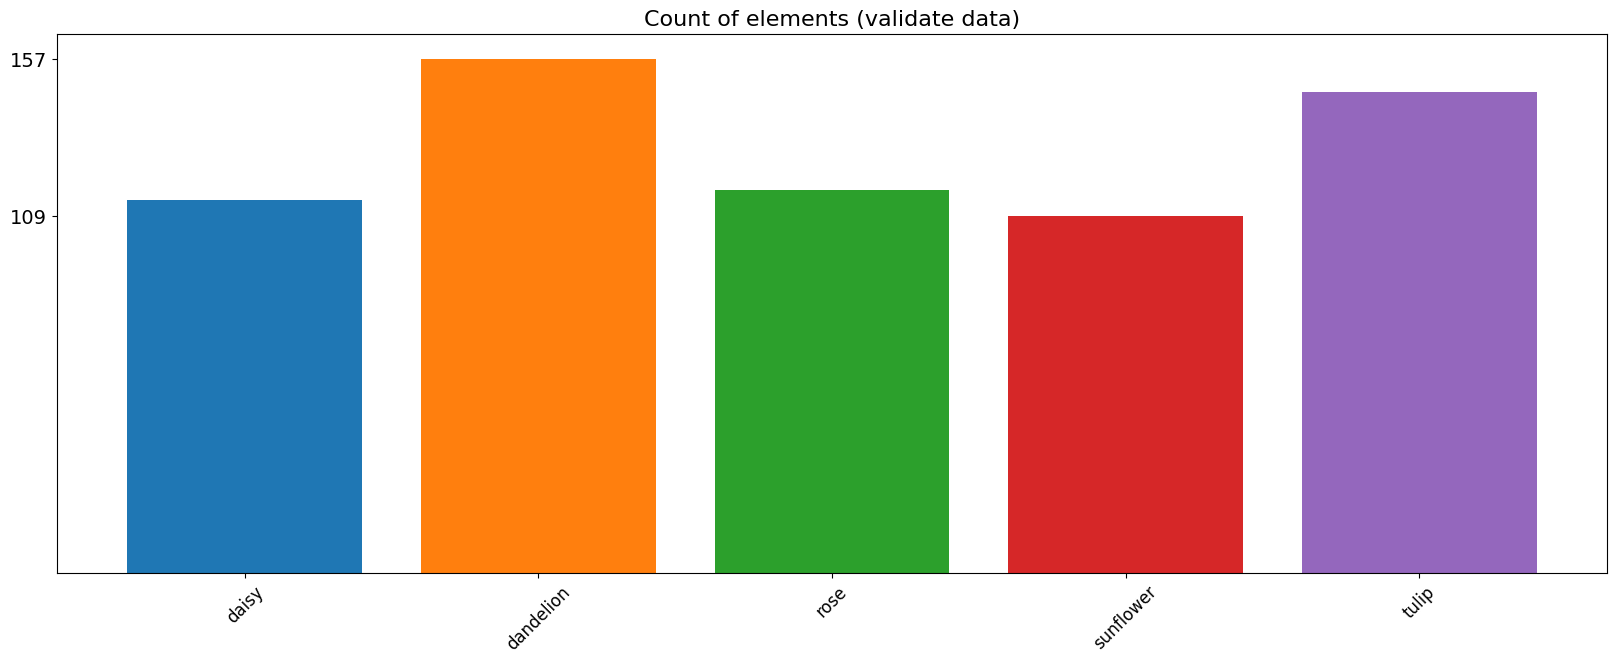

In [287]:
labels_count = {}

for image in data_validate.imgs:
    label = image[1]
    
    if label not in labels_count.keys():
        labels_count[label] = 0
    labels_count[label] += 1
    
class_counts = labels_count.copy()

#Visualize
plt.figure(figsize=(20, 7));

for n,key in enumerate(labels_count):
    plt.bar(list(labels_count.keys())[n],
            list(labels_count.values())[n]);  
    
plt.title('Count of elements (validate data)', fontsize=16)
plt.xticks(range(len(data_validate.classes)), data_validate.classes, rotation=45, fontsize=12)
plt.yticks((min(list(labels_count.values())), max(list(labels_count.values()))), fontsize=14)
plt.show()

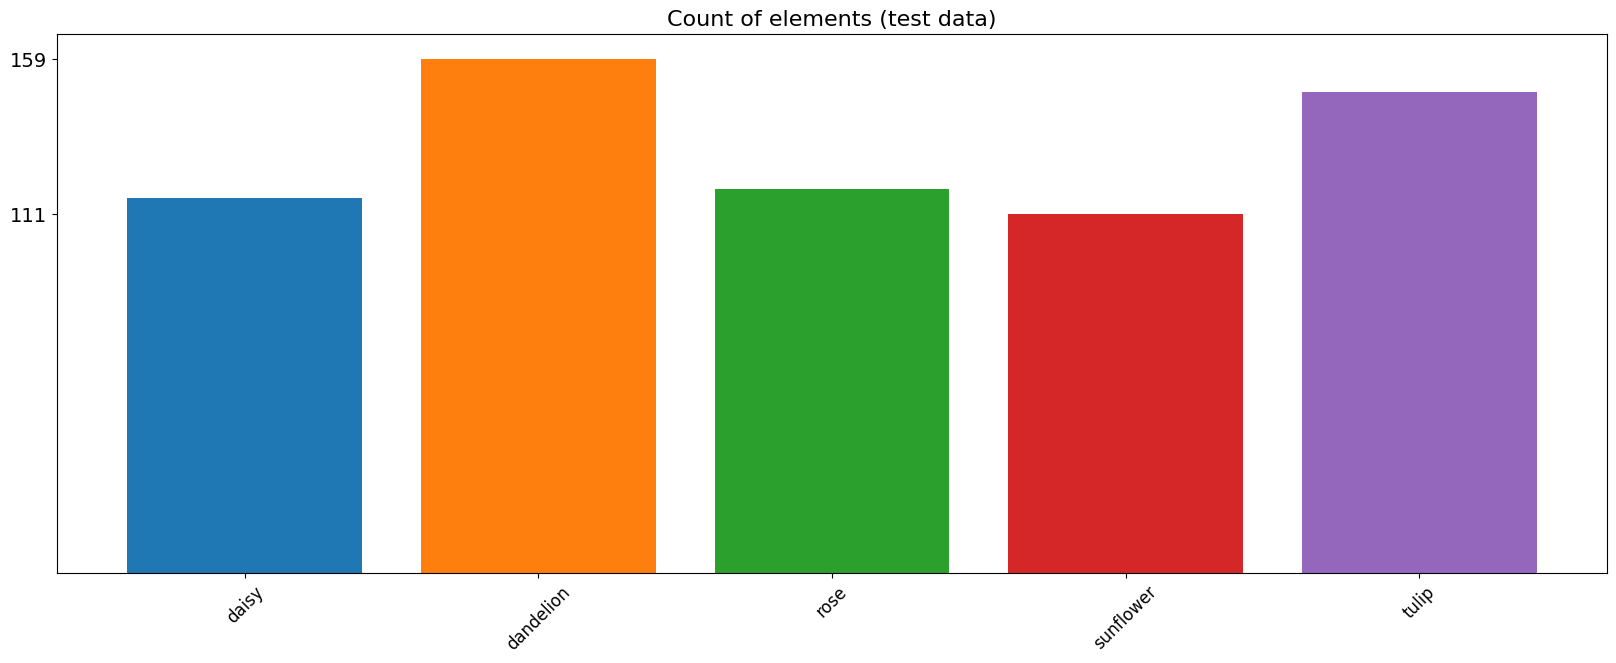

In [288]:
labels_count = {}

for image in data_test.imgs:
    label = image[1]
    
    if label not in labels_count.keys():
        labels_count[label] = 0
    labels_count[label] += 1
    
class_counts = labels_count.copy()

#Visualize
plt.figure(figsize=(20, 7));

for n,key in enumerate(labels_count):
    plt.bar(list(labels_count.keys())[n],
            list(labels_count.values())[n]);  
    
plt.title('Count of elements (test data)', fontsize=16)
plt.xticks(range(len(data_test.classes)), data_test.classes, rotation=45, fontsize=12)
plt.yticks((min(list(labels_count.values())), max(list(labels_count.values()))), fontsize=14)
plt.show()

In [289]:
def show_random_image():
    index = np.random.randint(0,len(dataset))
    return dataset[index]

In [290]:
img, label = show_random_image()

([], [])

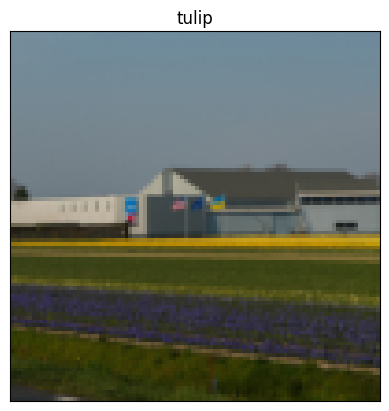

In [291]:
img, label = show_random_image()
plt.title(dataset.classes[label])
plt.imshow(img.permute(1, 2, 0))
plt.xticks([])
plt.yticks([])

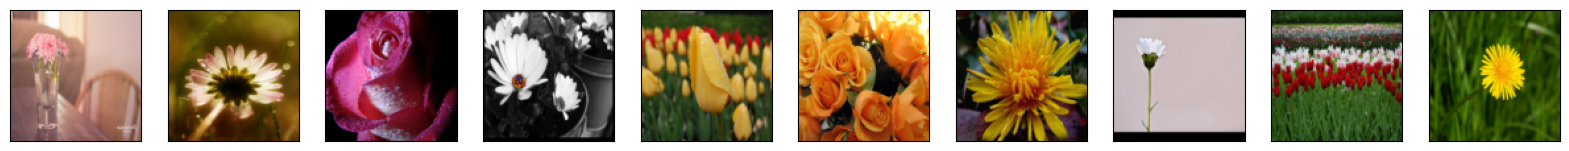

In [292]:
fig = plt.figure(figsize=(20,5))
for i in range(1,11):
    
    
    img, label = show_random_image()
    plt.subplot(1,10, i,)
    plt.imshow(img.permute(1, 2, 0))
    plt.xticks([])
    plt.yticks([])

In [293]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [294]:


def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history



In [295]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [296]:
train_loader = DataLoader(dataset, len(dataset), shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(data_validate, len(data_validate), num_workers=4, pin_memory=True)
test_loader = DataLoader(data_test, len(data_test), num_workers=4, pin_memory=True)

In [297]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [298]:
input_size = 3*100*100
output_size = 5 # Number of classe

In [299]:
class Model(ImageClassificationBase):
    def __init__(self, input_size, output_size):
        super().__init__()
        # hidden layer
        self.in_layer = nn.Linear(input_size, 512)
        self.hidden1 = nn.Linear(512, 256)
        self.hidden2 = nn.Linear(256, 256)
        self.hidden3 = nn.Linear(256, 128)
        # Output layer
        self.out_layer = nn.Linear(128, output_size)
        
    def forward(self, xb):
        out = xb.view(xb.size(0), -1)
        out = self.in_layer(out)
        out = self.hidden1(F.relu(out))
        out = self.hidden2(F.relu(out))
        out = self.hidden3(F.relu(out))
        out = self.out_layer(F.relu(out))
        return out

In [300]:
model = to_device(Model(input_size, output_size), device)

In [301]:
history = [evaluate(model, val_loader)]
history

RuntimeError: mat1 and mat2 shapes cannot be multiplied (644x256 and 512x256)

In [ ]:
history += fit(7, 0.01, model, train_loader, val_loader)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.6110, val_loss: 1.6109, val_acc: 0.1693


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.6110, val_loss: 1.6108, val_acc: 0.1693


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.6109, val_loss: 1.6108, val_acc: 0.1739


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.6109, val_loss: 1.6107, val_acc: 0.1786


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.6108, val_loss: 1.6107, val_acc: 0.1786


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5], train_loss: 1.6108, val_loss: 1.6107, val_acc: 0.1786


  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
history += fit(8, 0.001, model, train_loader, val_loader)

In [ ]:
history += fit(3, 0.0001, model, train_loader, val_loader)

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model, test_loader)